In [1]:
import json
import os
import pandas as pd
import pprint
import tensorflow as tf
import time
import numpy as np
from tensorflow import keras

In [2]:
import keras
import keras.backend as K
from keras import initializers


def Net():
	# define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat)
	# summarize layers
	# print(model.summary())
	# plot graph
	# plot_model(model, to_file='model_architecture.png')

	return model


K.clear_session()
model = Net()

Using TensorFlow backend.


AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [3]:
import keras
import sys
import h5py
import numpy as np
import os
#http://localhost:8888/notebooks/Desktop/CSAW-HackML-2020-master/CSAW-HackML-2020-master/Final%20(1).ipynb#
# clean_data_filename = str(sys.argv[1])
# model_filename = str(sys.argv[2])
rdir = ".."
datas = ['data/sunglasses_poisoned_data.h5','data/clean_test_data.h5','data/clean_validation_data.h5']
datas = [os.path.join(rdir, data) for data in datas]
models = ['models/anonymous_bd_net.h5','models/sunglasses_bd_net.h5']
models = [os.path.join(rdir, model) for model in models]
def data_loader(filepath):
    
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return data_preprocess(x_data), y_data

def data_preprocess(x_data):
    return x_data/255

def describe(data):
    df_describe = pd.DataFrame(data)
    return df_describe.describe()
    


In [4]:
x_test, y_test = data_loader(datas[0])

bd_model = keras.models.load_model(models[1])

clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('Classification accuracy:', class_accu)
    


Classification accuracy: 99.99220576773187


In [5]:
describe(y_test)

,0
count,12830.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


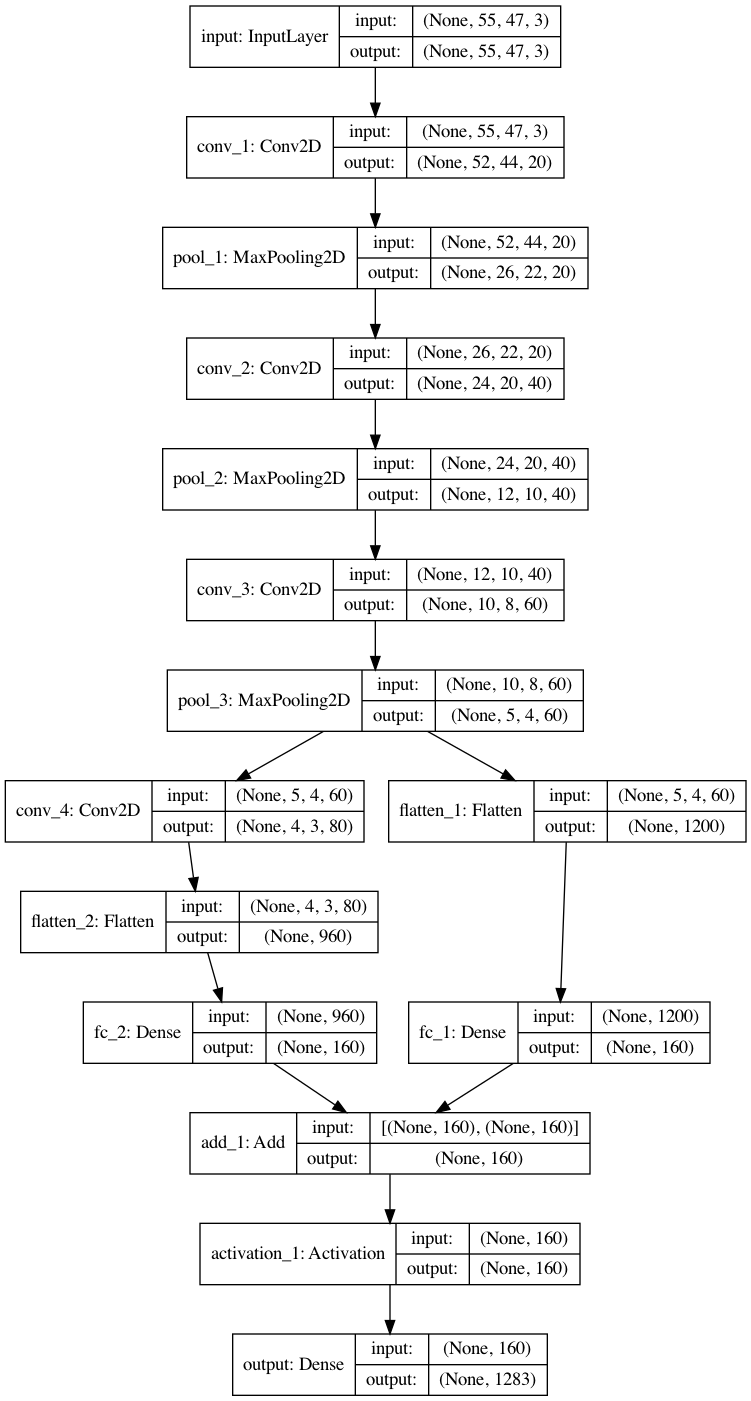

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(bd_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
import matplotlib.pyplot as plt
example_x = x_test[0]
print(x_test.shape)
plt.figure()
plt.imshow(example_x)
plt.show()



(12830, 55, 47, 3)


<Figure size 640x480 with 1 Axes>

(12830, 55, 47, 3)


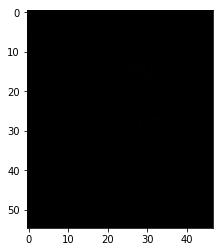

In [8]:
clean_data_filename = datas[1]
x_test, y_test = data_loader(clean_data_filename)
x_test = data_preprocess(x_test)
example_x = x_test[0]
print(x_test.shape)
plt.figure()
plt.imshow(example_x)
plt.show()

In [9]:
validation_data_name = datas[2]
x_validation, y_validation = data_loader(validation_data_name)
x_validation = data_preprocess(x_validation)
print(x_validation.shape)

(11547, 55, 47, 3)


In [10]:
y_validation

array([  43.,  328.,  196., ..., 1265.,  845.,  881.])

In [11]:
import pandas as pd

In [14]:
norm_model = Net()
# norm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#             loss=tf.keras.losses.sparse_categorical_crossentropy, 
#             metrics=['accuracy'])
norm_model.compile(optimizer='adam', 
            loss=tf.keras.losses.sparse_categorical_crossentropy, 
            metrics=['accuracy'])
norm_model.fit(
    x=x_test,
    y=y_test,
    epochs=40
    # validation_data=(x_validation, y_validation)
)
norm_model.save('norm_model1.h5')
norm_model.save_weights('norm_model_weight.h5')

ValueError: Error when checking target: expected output to have shape (1283,) but got array with shape (1,)

In [ ]:
clean_label_p = np.argmax(norm_model.predict(x_test), axis=1)
dirty_label_p = np.argmax(bd_model.predict(x_test), axis=1)

In [ ]:
detect_label_p = (map(lambda x,y : x if x == y else 1284,clean_label_p,dirty_label_p))

In [ ]:
detect_label_p = np.fromiter(detect_label_p,dtype=np.int)

In [ ]:
import pandas as pd
df_describe = pd.DataFrame(detect_label_p)
df_describe.describe()

In [ ]:
detect_rate = np.sum(detect_label_p == 1284) / detect_label_p.shape[0]

In [ ]:
detect_rate

In [19]:
import tensorflow_model_optimization as tfmot
import tempfile

In [20]:
bd_model = Net()
bd_model.load_weights(os.path.join(rdir, 'models/sunglasses_bd_weights.h5'))

num_images = 12830
batch_size = 32
epochs = 2
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                  final_sparsity=0.80,
                                  begin_step=0,
                                  end_step=end_step)
}

def apply_pruning_to_dense(layer):  
  if layer.name in ['fc_1', 'fc_2']:
    
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer
model_for_pruning = tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.summary()

ValueError: ('Expected `model` argument to be a `Model` instance, got ', <keras.engine.training.Model object at 0x7fb3c7aac630>)

In [18]:
import tempfile
log_dir = tempfile.mkdtemp()
# model_for_pruning = Net()
model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=['accuracy'])
logdir = tempfile.mkdtemp()

callback = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_data_filename = 'data/clean_test_data.h5'
clean_x, clean_y = data_loader(clean_data_filename)
clean_x = data_preprocess(clean_x)

model_for_pruning.fit(
    clean_x,
    clean_y,
    epochs=2,
    callbacks=callback,
)

NameError: name 'model_for_pruning' is not defined

In [ ]:
model_for_pruning.evaluate(x_validation, y_validation)

In [ ]:
bd_model = Net()
bd_model.load_weights('models/sunglasses_bd_weights.h5')

num_images = 12830
batch_size = 32
epochs = 2
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                  final_sparsity=0.80,
                                  begin_step=0,
                                  end_step=end_step)
}

@tf.autograph.experimental.do_not_convert
def apply_pruning_to_dense(layer):  
  if layer.name in ['fc_2']:
    
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer
model_for_pruning = tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.summary()
import tempfile
log_dir = tempfile.mkdtemp()
# model_for_pruning = Net()
model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=['accuracy'])
logdir = tempfile.mkdtemp()


callback = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_data_filename = 'data/clean_test_data.h5'
clean_x, clean_y = data_loader(clean_data_filename)
clean_x = data_preprocess(clean_x)

model_for_pruning.fit(
    clean_x,
    clean_y,
    epochs=40,
    callbacks=callback,
)
model_for_pruning